In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0621/weights_KD_segformer_0621_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 9s - loss: 0.0611

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 574ms/step - loss: 0.0332
Average validation loss: 0.29624810814857483
4/4 [==============================] - 5s 583ms/step - loss: 0.0332 - val_loss: 0.2962
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 591ms/step - loss: 0.0187 - val_loss: 0.2962
Average validation loss: 0.15665853023529053
4/4 [==============================] - 7s 603ms/step - loss: 0.0187 - val_loss: 0.2265
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 588ms/step - loss: 0.0128 - val_loss: 0.2265
Average validation loss: 0.1630677431821823
4/4 [==============================] - 10s 599ms/step - loss: 0.0128 - val_lo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 722ms/step - loss: 3.9607e-05
Average validation loss: 4.6933830162743106e-05
8/8 [==============================] - 6s 732ms/step - loss: 3.9607e-05 - val_loss: 4.6934e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 724ms/step - loss: 3.9109e-05 - val_loss: 4.6934e-05
Average validation loss: 8.795267625316683e-09
8/8 [==============================] - 12s 736ms/step - loss: 3.9109e-05 - val_loss: 2.3471e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 774ms/step - loss: 3.8633e-05 - val_loss: 2.3471e-05
Average validation loss: 9.100844522436091e-08
8/8 [========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 703ms/step - loss: 8.3545e-05
Average validation loss: 0.03109258752131912
12/12 [==============================] - 9s 713ms/step - loss: 8.3545e-05 - val_loss: 0.0311
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 691ms/step - loss: 8.2555e-05 - val_loss: 0.0311
Average validation loss: 0.024165363831950042
12/12 [==============================] - 17s 705ms/step - loss: 8.2555e-05 - val_loss: 0.0276
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 709ms/step - loss: 7.9000e-05 - val_loss: 0.0276
Average validation loss: 0.028572258384277422
12/12 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 716ms/step - loss: 5.3776e-05
Average validation loss: 0.10094939264956793
16/16 [==============================] - 12s 727ms/step - loss: 5.3776e-05 - val_loss: 0.1009
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 695ms/step - loss: 5.0170e-05 - val_loss: 0.1009
Average validation loss: 0.03598120690730866
16/16 [==============================] - 23s 705ms/step - loss: 5.0170e-05 - val_loss: 0.0685
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 34s 694ms/step - loss: 4.6908e-05 - val_loss: 0.0685
Average validation loss: 0.0674104044901469
16/16 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 712ms/step - loss: 2.5448e-05
Average validation loss: 0.044468443864025174
20/20 [==============================] - 14s 723ms/step - loss: 2.5448e-05 - val_loss: 0.0445
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 707ms/step - loss: 2.7759e-05 - val_loss: 0.0445
Average validation loss: 0.08909504081402701
20/20 [==============================] - 29s 717ms/step - loss: 2.7759e-05 - val_loss: 0.0668
Epoch 3/10
20/20 [==============================] - 43s 728ms/step - loss: 2.5325e-05 - val_loss: 0.0668
Average validation loss: 0.05286670703208074
20/20 [==============================] - 43s 739ms/step - loss: 2.5325e-05 - val_loss: 0.0621
Epoch 4/10
20/20 [==============================] - 58s 706ms/step - loss: 2.3045e-05 - val_loss: 0.0621
Average validati

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 741ms/step - loss: 7.5603e-05
Average validation loss: 0.072321983675162
24/24 [==============================] - 18s 751ms/step - loss: 7.5603e-05 - val_loss: 0.0723
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 715ms/step - loss: 5.4987e-05 - val_loss: 0.0723
Average validation loss: 0.05028501898050308
24/24 [==============================] - 35s 725ms/step - loss: 5.4987e-05 - val_loss: 0.0613
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 701ms/step - loss: 4.3890e-05 - val_loss: 0.0613
Average validation loss: 0.15622117867072424
24/24 [==============================] - 5

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 727ms/step - loss: 1.1080e-04
Average validation loss: 0.1600664608180523
40/40 [==============================] - 30s 738ms/step - loss: 1.1080e-04 - val_loss: 0.1601
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 705ms/step - loss: 9.1888e-05 - val_loss: 0.1601
Average validation loss: 0.13931712582707406
40/40 [==============================] - 58s 715ms/step - loss: 9.1888e-05 - val_loss: 0.1497
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 86s 703ms/step - loss: 8.1708e-05 - val_loss: 0.1497
Average validation loss: 0.1023356057703495
40/40 [==============================] - 8

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 713ms/step - loss: 6.4572e-05
Average validation loss: 0.09296822103472853
48/48 [==============================] - 35s 724ms/step - loss: 6.4572e-05 - val_loss: 0.0930
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 714ms/step - loss: 4.6988e-05 - val_loss: 0.0930
Average validation loss: 0.13132532451728215
48/48 [==============================] - 70s 724ms/step - loss: 4.6988e-05 - val_loss: 0.1121
Epoch 3/10
48/48 [==============================] - 104s 720ms/step - loss: 3.9676e-05 - val_loss: 0.1121
Average validation loss: 0.09573132248866993
48/48 [==============================] - 105s 730ms/step - loss: 3.9676e-05 - val_loss: 0.1067
Epoch 4/10
48/48 [==============================] - 139s 706ms/step - loss: 4.4629e-05 - val_loss: 0.1067
Average valida

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 705ms/step - loss: 6.2235e-05
Average validation loss: 0.2562503274585147
56/56 [==============================] - 40s 716ms/step - loss: 6.2235e-05 - val_loss: 0.2563
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 707ms/step - loss: 4.7267e-05 - val_loss: 0.2563
Average validation loss: 0.11727123884429602
56/56 [==============================] - 80s 717ms/step - loss: 4.7267e-05 - val_loss: 0.1868
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 711ms/step - loss: 3.7007e-05 - val_loss: 0.1868
Average validation loss: 0.11512407826457352
56/56 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 704ms/step - loss: 5.9624e-05
Average validation loss: 0.14031957584835197
64/64 [==============================] - 46s 715ms/step - loss: 5.9624e-05 - val_loss: 0.1403
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 91s 704ms/step - loss: 4.3173e-05 - val_loss: 0.1403
Average validation loss: 0.11215754181228021
64/64 [==============================] - 92s 714ms/step - loss: 4.3173e-05 - val_loss: 0.1262
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 137s 713ms/step - loss: 3.3722e-05 - val_loss: 0.1262
Average validation loss: 0.11852256277711604
64/64 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 711ms/step - loss: 4.2152e-05
Average validation loss: 0.08160416430069341
72/72 [==============================] - 52s 721ms/step - loss: 4.2152e-05 - val_loss: 0.0816
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 730ms/step - loss: 2.9900e-05 - val_loss: 0.0816
Average validation loss: 0.15141629386279318
72/72 [==============================] - 105s 740ms/step - loss: 2.9900e-05 - val_loss: 0.1165
Epoch 3/10
72/72 [==============================] - 156s 703ms/step - loss: 2.2905e-05 - val_loss: 0.1165
Average validation loss: 0.09319416868189971
72/72 [==============================] - 157s 713ms/step - loss: 2.2905e-05 - val_loss: 0.1087
Epoch 4/10
72/72 [==============================] - 207s 704ms/step - loss: 1.8637e-05 - val_loss: 0.1087
Average vali

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 708ms/step - loss: 3.6312e-05
Average validation loss: 0.09924710486084223
80/80 [==============================] - 57s 718ms/step - loss: 3.6312e-05 - val_loss: 0.0992
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 704ms/step - loss: 2.5928e-05 - val_loss: 0.0992
Average validation loss: 0.11216358672827483
80/80 [==============================] - 115s 715ms/step - loss: 2.5928e-05 - val_loss: 0.1057
Epoch 3/10
80/80 [==============================] - 171s 704ms/step - loss: 2.0185e-05 - val_loss: 0.1057
Average validation loss: 0.0882958160713315
80/80 [==============================] - 172s 714ms/step - loss: 2.0185e-05 - val_loss: 0.0999
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 710ms/step - loss: 7.1524e-05
Average validation loss: 0.21959640192609223
96/96 [==============================] - 69s 720ms/step - loss: 7.1524e-05 - val_loss: 0.2196
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 137s 702ms/step - loss: 5.2741e-05 - val_loss: 0.2196
Average validation loss: 0.16096866295878462
96/96 [==============================] - 138s 712ms/step - loss: 5.2741e-05 - val_loss: 0.1903
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 205s 707ms/step - loss: 4.0316e-05 - val_loss: 0.1903
Average validation loss: 0.18724489077770082
96/96 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 711ms/step - loss: 4.2542e-05
Average validation loss: 0.11152826440326559
120/120 [==============================] - 87s 722ms/step - loss: 4.2542e-05 - val_loss: 0.1115
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 171s 706ms/step - loss: 3.1450e-05 - val_loss: 0.1115
Average validation loss: 0.13331940357969263
120/120 [==============================] - 173s 716ms/step - loss: 3.1450e-05 - val_loss: 0.1224
Epoch 3/10
120/120 [==============================] - 257s 706ms/step - loss: 2.4478e-05 - val_loss: 0.1224
Average validation loss: 0.11641122062671154
120/120 [==============================] - 258s 716ms/step - loss: 2.4478e-05 - val_loss: 0.1204
Epoch 4/10
120/120 [==============================] - 344s 710ms/step - loss: 2.0132e-05 - val_loss: 0.12

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 102s 709ms/step - loss: 2.9718e-05
Average validation loss: 0.10798969917525231
144/144 [==============================] - 104s 719ms/step - loss: 2.9718e-05 - val_loss: 0.1080
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 206s 710ms/step - loss: 2.2493e-05 - val_loss: 0.1080
Average validation loss: 0.11077929546531272
144/144 [==============================] - 207s 721ms/step - loss: 2.2493e-05 - val_loss: 0.1094
Epoch 3/10
144/144 [==============================] - 309s 705ms/step - loss: 1.8316e-05 - val_loss: 0.1094
Average validation loss: 0.11418434630940687
144/144 [==============================] - 310s 715ms/step - loss: 1.8316e-05 - val_loss: 0.1110
Epoch 4/10
144/144 [==============================] - 412s 706ms/step - loss: 1.6510e-05 - val_loss: 0.

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 123s 770ms/step - loss: 1.8994e-05
Average validation loss: 0.24068904116451204
160/160 [==============================] - 125s 781ms/step - loss: 1.8994e-05 - val_loss: 0.2407
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 248s 771ms/step - loss: 1.5396e-05 - val_loss: 0.2407
Average validation loss: 0.12233995704164613
160/160 [==============================] - 250s 782ms/step - loss: 1.5396e-05 - val_loss: 0.1815
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 373s 770ms/step - loss: 1.2591e-05 - val_loss: 0.1815
Average validation loss: 0.1361136643740565
160/160 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 155s 772ms/step - loss: 5.4051e-05
Average validation loss: 0.16053481952122867
200/200 [==============================] - 157s 783ms/step - loss: 5.4051e-05 - val_loss: 0.1605
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 310s 767ms/step - loss: 4.0036e-05 - val_loss: 0.1605
Average validation loss: 0.13750444065193507
200/200 [==============================] - 312s 777ms/step - loss: 4.0036e-05 - val_loss: 0.1490
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 465s 766ms/step - loss: 3.1972e-05 - val_loss: 0.1490
Average validation loss: 0.11044288018058068
200/200 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:19 - loss: 2.5942e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 185s 770ms/step - loss: 2.7014e-05
Average validation loss: 0.14575602162461793
240/240 [==============================] - 188s 781ms/step - loss: 2.7014e-05 - val_loss: 0.1458
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0621/weights_KD_segformer_0621_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 373s 771ms/step - loss: 1.9148e-05 - val_loss: 0.1458
Average validation loss: 0.15689596881603915
240/240 [==============================] - 375s 782ms/step - loss: 1.9148e-05 - val_loss: 0.1513
Epoch 3/10
240/240 [==============================] - 559s 767ms/step - loss: 1.5170e-05 - val_loss: 0.1513
Average validation loss: 0.1301573227309092
240/240 [==============================] - 562s 778ms/step - loss: 1.5170e-05 - val_loss: 0.1443
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_s

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.031211242889462483, 0.03702895182729014, 0.07621788874996999, 0.07807040013013307, 0.057723532910801165, 0.06286859308593648, 0.09624168297182431, 0.11778542868561953, 0.11447927874423475, 0.11329215650308534, 0.10984533808694213, 0.11096394814835192, 0.12573584824152892, 0.10488114060240841, 0.12151812158487947, 0.12960877884359356, 0.14191893632687247, 0.1369793773617701]
std_val_losses =  [0.05504392946736068, 0.02858570121672232, 0.045503384118466106, 0.031139526532668587, 0.019330429041533863, 0.03425892332900524, 0.028438134375017785, 0.10826719006244372, 0.05807536866769228, 0.04154601708043984, 0.030606641815241795, 0.024713928131672298, 0.04655332164875041, 0.022396345696599897, 0.01812210667544823, 0.0397830354815124, 0.019204860453170443, 0.027759818496445068]


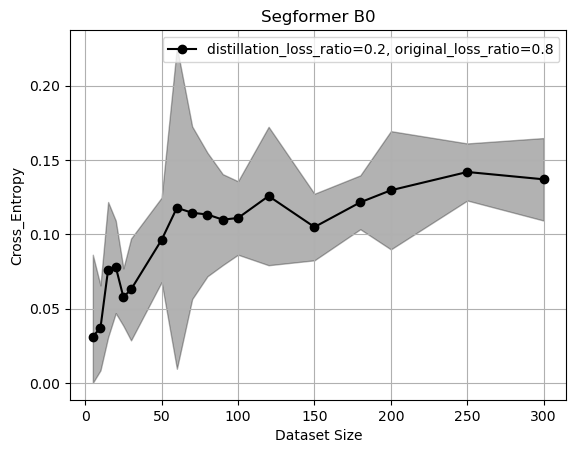

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0621')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0621_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0621_{int(teacher_ratio*100)}.png"))

plt.show()